## 環境構築とライブラリの準備

本プロジェクトでは、XGBoostを用いた回帰モデルの構築と評価を目的として、以下の主要なライブラリやツールをインポートしている

### データ処理関連
- `pandas`, `numpy`: データの読み込み、前処理や数値計算に使用
- `random`: 乱数の制御（再現性確保のため）
- `train_test_split`: scikit-learnによるデータセットの学習用とテスト用への分割

### モデル構築・学習関連
- `xgboost`: 高性能な勾配ブースティングライブラリで、回帰モデルの構築に使用

### 評価指標
- `mean_squared_error`, `mean_absolute_error`, `r2_score`: 回帰モデルの性能評価に用いる指標

### 可視化関連
- `matplotlib`, `seaborn`: データ分布や学習結果の可視化に使用

### 再現性の確保
- 実験の再現性を担保するため、`random` と `numpy` の乱数シードを固定


In [83]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 再現性の確保 ---
random.seed(42)
np.random.seed(42)

## データ前処理と特徴量エンジニアリング

体温・室温データから「適温」を予測するため、以下のような特徴量エンジニアリングと前処理を行いました。  
主にラグ特徴量・差分・移動統計量の導入による時系列的な情報の拡充を目的としています。

- データセット `ring_data.csv` または`ias_data.csv` を読み込み
- ラグ特徴量（1時刻前の体温・室温）  
  - `体温_lag1`, `室温_lag1`
- 差分特徴量（体温と室温の差とそのラグ）  
  - `delta_temp`, `delta_temp_lag1`
- 移動統計量（ウィンドウサイズ3）  
  - 移動平均：`体温_ma3`, `室温_ma3`  
  - 移動最大：`体温_max3`, `室温_max3`  
  - 移動最小：`体温_min3`, `室温_min3`
- 2次差分（温度差の加速度的変化）：`delta_temp_2diff`
- 欠損値の除去（`shift` や `rolling` によるNaNの削除）
- モデル入力として用いる特徴量を10種に選定
- 目的変数（ターゲット）は `適温` 列を使用
- 時系列の順序を保持したまま、学習用・テスト用にデータを8:2に分割（`shuffle=False`）




In [84]:
# --- データ読み込み ---
df = pd.read_csv("../datasets/ias_data.csv")

# --- ラグ特徴量 ---
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)

# --- 差分特徴量 ---
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']

# --- 移動平均、最大・最小（ウィンドウサイズ3） ---
window_size = 3
df['体温_ma3'] = df['体温'].rolling(window=window_size).mean()
df['体温_max3'] = df['体温'].rolling(window=window_size).max()
df['体温_min3'] = df['体温'].rolling(window=window_size).min()

df['室温_ma3'] = df['室温'].rolling(window=window_size).mean()
df['室温_max3'] = df['室温'].rolling(window=window_size).max()
df['室温_min3'] = df['室温'].rolling(window=window_size).min()


# --- 使用特徴量とターゲット ---
features = [
    '体温', '体温_ma3', '体温_max3', '体温_min3', 
    '室温', '室温_lag1', '室温_ma3', '室温_max3', '室温_min3'
]
target = '適温'

# --- データ準備 ---
X = df[features].values
y = df[target].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False, random_state=42
)

print("Train target stats:", y_train.mean(), y_train.std())
print("Eval  target stats:", y_val.mean(), y_val.std())
print("Test  target stats:", y_test.mean(), y_test.std())


Train target stats: 21.40489795918367 1.301261746323473
Eval  target stats: 19.95645161290323 0.3531521502229255
Test  target stats: 19.368831168831175 0.730283656019552


## XGBoostによる回帰モデル構築と高精度化の工夫

### データ構造の最適化
- 学習データ・テストデータをXGBoostの高速処理に適した`DMatrix`形式に変換し、メモリ効率と処理速度を向上

###  ハイパーパラメータの詳細チューニング
- 目的関数は回帰問題に適した`reg:squarederror`を選択
- 木の深さや学習率は過学習を防ぐために控えめな値を設定
- サブサンプリングおよび特徴量サンプリングにより、学習ごとに異なるデータと特徴を使うことでモデルの汎化性能を高めた
- L1正則化とL2正則化を導入し、不要なパラメータの影響を抑制
- `min_child_weight=3`と`gamma=1.0`により、分割時の条件を厳しく設定し、ノイズへの過適合を軽減。
- ツリー成長アルゴリズムに**hist**（高速ヒストグラム方式）と**lossguide**（損失減少に基づく成長方針）を指定し、大規模データに対しても効率的かつ精度良く学習可能にした


### 学習制御
- 最大100ラウンドのブースティングを行う一方、early_stopping_rounds=10を設定し、検証データでの性能向上が見られなくなった時点で学習を終了。これにより過学習を防ぐ








[0]	train-rmse:1.28974	eval-rmse:1.47371
[20]	train-rmse:1.08503	eval-rmse:1.23207
[40]	train-rmse:0.91371	eval-rmse:1.03513
[60]	train-rmse:0.77364	eval-rmse:0.87039
[80]	train-rmse:0.65614	eval-rmse:0.72917
[100]	train-rmse:0.55907	eval-rmse:0.61275
[120]	train-rmse:0.47894	eval-rmse:0.51909
[140]	train-rmse:0.41276	eval-rmse:0.43934
[160]	train-rmse:0.35682	eval-rmse:0.37179
[180]	train-rmse:0.31117	eval-rmse:0.31788
[200]	train-rmse:0.27286	eval-rmse:0.26929
[220]	train-rmse:0.24099	eval-rmse:0.23144
[240]	train-rmse:0.21485	eval-rmse:0.19720
[249]	train-rmse:0.20470	eval-rmse:0.18437


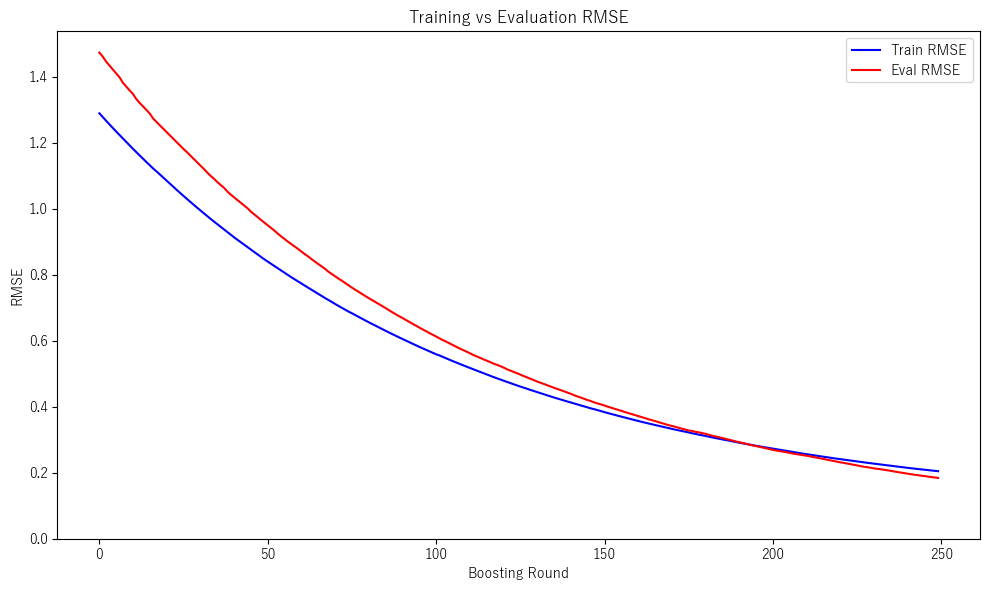

In [85]:
# --- DMatrix作成 ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- パラメータ設定 ---
params = {
    'objective': 'reg:squarederror',  # 回帰問題
    'eval_metric': 'rmse',            # 評価指標はRMSE
    'max_depth': 4,                   # 木の深さ最大4
    'learning_rate': 0.01,            # 学習率
    'subsample': 0.8,                 # 各決定木の学習に使うデータ(行）の割合
    'colsample_bytree': 0.8,          # 各決定木の学習に使う特徴量（列）の割合
    'colsample_bylevel': 0.8,         # 各レベルの分割に使う特徴量の割合
    'reg_alpha': 0.1,                 # L1正則化の強さ
    'reg_lambda': 1.5,                # L2正則化の強さ
    'min_child_weight': 3,            # 葉の分割に必要な最小サンプル重みの合計
    'gamma': 0.2,                    # 木の分割に必要な最小損失減少量
    'tree_method': 'exact',           # ヒストグラムベースの高速木構築法
    'grow_policy': 'depthwise',      # 木の成長戦略
    'seed': 42                      # 乱数シード
}


evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

# --- モデル学習 ---
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=250,
    evals=evals,
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=20
)

# --- 学習履歴の取得 ---
train_rmse = evals_result['train']['rmse']
eval_rmse = evals_result['eval']['rmse']

# --- 損失の推移を可視化 ---
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(eval_rmse, label='Eval RMSE', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training vs Evaluation RMSE')
plt.legend()
plt.grid(False)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()



### モデル評価
- テストデータに対して予測を行い、複数の指標で評価しました。
  - MSE：誤差の二乗平均で全体の精度を定量化
  - RMSE：誤差の大きさを直感的に把握できる単位で評価
  - MAE：誤差の絶対値平均で外れ値の影響を軽減
  - R²スコア：モデルの説明力を示す指標
  - in_comfort_range：予測値がユーザの快適温度範囲内に収まっていた割合。、1でない場合は快適さを損なう予測が含まれている
  - median_distance：快適範囲の中央値と予測値の絶対誤差の平均

これらの多角的な評価により、モデルの予測精度と汎化性能、さらにはユーザ体験に基づく快適性のバランスを総合的に確認


In [86]:
# --- 予測と評価 ---
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2 Score: {r2:.4f}")
comfort_range_min = y_test.min()
comfort_range_max = y_test.max()
print(f"{comfort_range_min},{comfort_range_max}")
comfort_center = (comfort_range_min + comfort_range_max) / 2 

# 予測値が適温帯に含まれている割合
in_comfort_range = ((y_pred >= comfort_range_min) & (y_pred <= comfort_range_max)).mean()
print(f"Comfort Range Accuracy : {in_comfort_range * 100:.2f}%")

# 中央値との差分
median_distance = np.mean(np.abs(y_pred - comfort_center))
print(f"Mean Distance to Comfort Center ({comfort_center}°C): {median_distance:.4f}")


Test MSE: 0.1455
Test RMSE: 0.3814
Test MAE: 0.3261
Test R^2 Score: 0.7272
17.9,20.6
Comfort Range Accuracy : 97.40%
Mean Distance to Comfort Center (19.25°C): 0.7684


### 特徴量とターゲットとの相関関係の可視化


- 相関行列を `seaborn.heatmap` により可視化し、全体の傾向を直感的に把握できる
- 正の相関・負の相関が色で表現され、特徴量選定の参考となる
---

### XGBoostによる特徴量重要度の可視化


- どの特徴量がモデル予測に強く影響を与えているかを確認することで、**特徴量エンジニアリングやモデル解釈性の向上**に役立つ

---

### 実測値と予測値の比較プロット

- テストデータ部分に対応するインデックスを抽出し、**時間変化における予測の精度**を視覚的に確認可能

=== ターゲットとの相関係数 ===
適温         1.000000
室温         0.979798
室温_ma3     0.978074
室温_min3    0.977662
室温_lag1    0.976480
室温_max3    0.975299
体温_max3    0.928773
体温_ma3     0.921089
体温         0.919855
体温_min3    0.902304
Name: 適温, dtype: float64


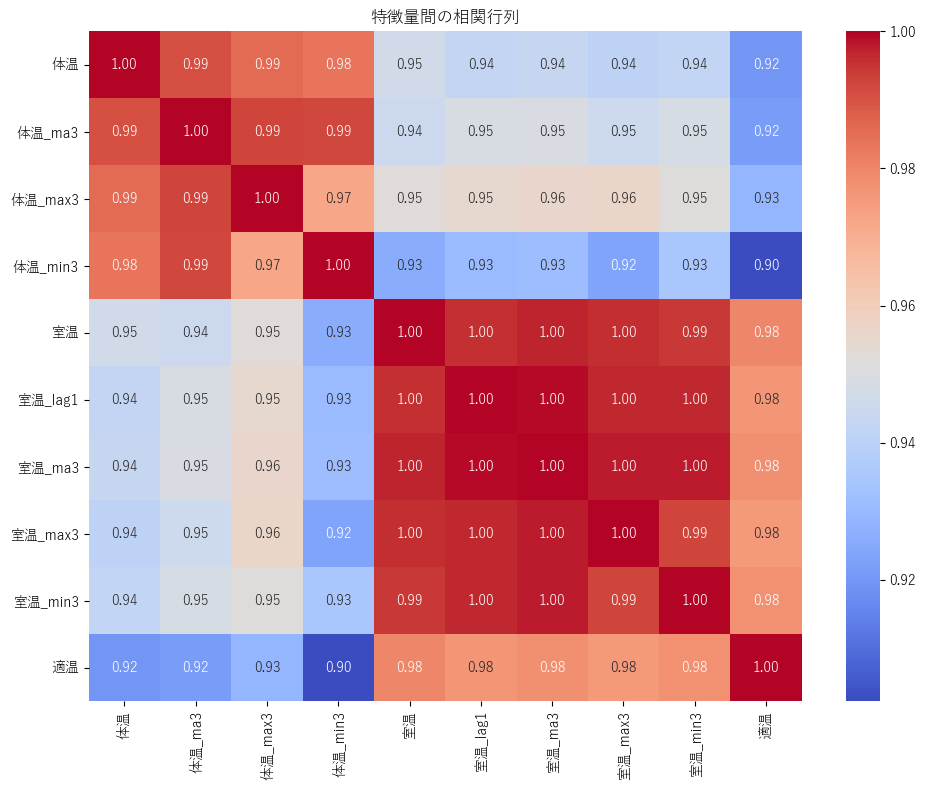


=== 特徴量重要度 ===
   feature  importance
4       室温       687.0
0       体温       464.0
7  室温_max3       129.0
1   体温_ma3       124.0
6   室温_ma3       110.0
8  室温_min3        61.0
2  体温_max3        53.0
3  体温_min3        38.0
5  室温_lag1        33.0


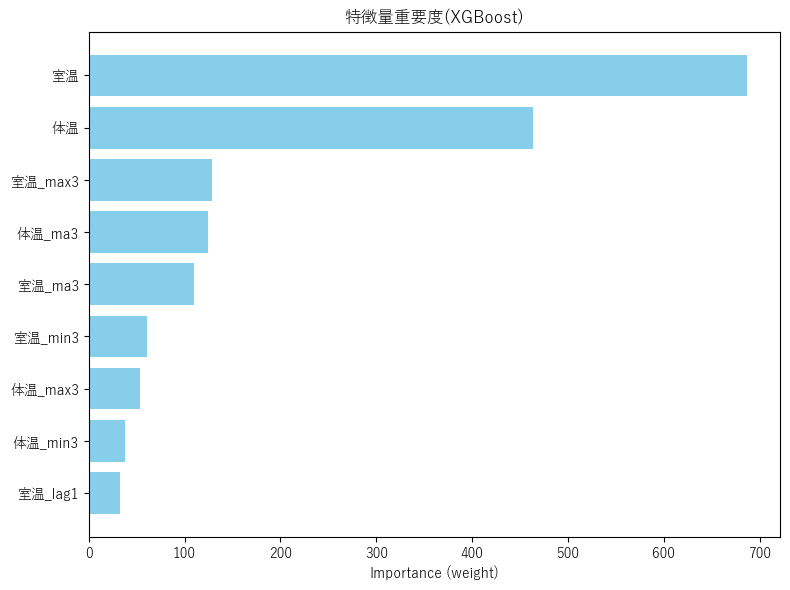

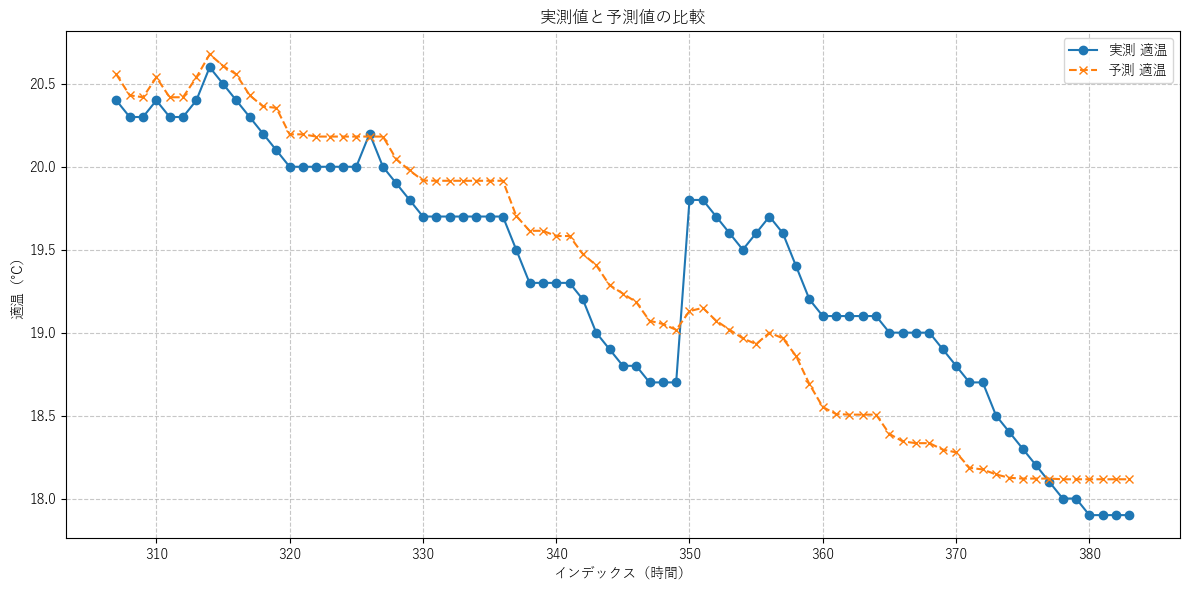

In [87]:
# --- 日本語フォントの設定 ---
plt.rcParams['font.family'] = 'Yu Gothic'  

# --- 相関行列の表示 ---
corr_matrix = df[features + [target]].corr()

print("=== ターゲットとの相関係数 ===")
print(corr_matrix[target].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('特徴量間の相関行列')
plt.tight_layout()
plt.show()


# --- 特徴量重要度の取得と可視化（XGBoost） ---
importance = model.get_score(importance_type='weight')
feat_imp_df = pd.DataFrame({
    'feature': features,
    'importance': [importance.get(f'f{i}', 0) for i in range(len(features))]
}).sort_values(by='importance', ascending=False)

print("\n=== 特徴量重要度 ===")
print(feat_imp_df)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance (weight)')
plt.title('特徴量重要度(XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# --- 予測値と実測値の比較プロット ---
# 元データのインデックスのうち、テストデータ部分を取得
test_index = df.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(test_index, y_test, label='実測 適温', marker='o', linestyle='-')
plt.plot(test_index, y_pred, label='予測 適温', marker='x', linestyle='--')
plt.xlabel('インデックス（時間）')
plt.ylabel('適温（℃）')
plt.title('実測値と予測値の比較')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



**CSVファイルへの保存**  
   指定したファイル名（`ring_xgb.csv`）でCSV形式で`.\results`へ保存し、保存パスを出力している



In [88]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2],
    "in_comfort_range" : [in_comfort_range],
    "median_distance" : [median_distance]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ias_xgb.csv"  

# フルパスを作成
filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")


評価結果を保存しました: ../results\ias_xgb.csv
